**Exercise set 9**
==============

>The goal of this exercise is to use PLSR regression for predicting concentrations from 
>from near-infrared spectra unsing partial least
>squares regression, and we will also do a PCA analysis.

**Exercise 9.1**

[Windig and Stephenson](https://doi.org/10.1021/ac00046a015) have measured near-infrared spectra
for 140 mixtures of the solvents methylene chloride, 2-butanol, methanol,
dichloropropane, and acetone. We will in this exercise see if we can
predict the compositions of the mixtures from the spectra.
Each of the $140$ spectra have been sampled at $700$ wavelengths
between $1100$ and $2500$ nm. The raw data containing the spectra
and the corresponding concentrations can be found in the file
[`Data/windig.csv`](Data/windig.csv).



**(a)**  Create a partial least squares regression (PLSR) model for predicting
the concentrations. Use $1$ PLS component for your first model and
assess it using $R^2$, RMSEC, RMSECV and RMSEP.

These values (RMSEC, RMSECV, and RMSEP) are all based on calculating the
root mean squared error (RMSE) given by,

\begin{equation}
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^N (y_i - \hat{y}_i)^2},
\tag{1}\end{equation}

where $y_i$ are our measured $y$-values and $\hat{y}_i$ are the
values predicted by our model. The difference between RMSEC,
RMSEP, and RMSECV lies in the part of the data we use to
calculate them. This is based on first splitting the data into
a *training* and *test* set, and then
performing what we call
*cross-validation* using
the training set:

*  When we use the training set to create our model, we are doing
   a *calibration*. If we calculate RMSE based on using
   the training set, we refer to this as the RMSEC (root mean squared
   error of calibration).
   This number
   quantifies the error we get in connection with making (calibrating)
   the model

*  When we use the test set to test our model, we are
   checking how well our model *predicts* "new" samples
   (that is, samples that were not used when making the model). If
   we calculate RMSE based on the training set, we refer to 
   this as the RMSEP (room mean squared error of prediction). This
   number quantifies the error we can expect to make when using
   our model for predicting samples that were not used when making
   the model.

*  Cross-validation is based on doing a further split
   of the training set. Typically, we split the training set into
   $k$ smaller subsamples and we repeat the fitting of the
   model $k$ times.
   For each time we repeat the fitting, we retain a single
   subsample for validation, and we fit the model using the
   $k-1$ other subsamples. For the subsample we retained
   for validation, we can calculate the RMSE value of how
   well this is predicted by our model. Since we repeat this $k$ times,
   we can make it so that each of the $k$ subsamples is
   used exactly once for validation. Finally, we can
   obtain the average RMSE of the $k$ fittings and we
   refer to this value as the RMSECV (root mean squared error
   of cross-validation). This number indicates how well
   our model predict samples that were obtained among
   the calibration cases.
   
   
Luckily, methods for splitting our data into training and test
sets, calculating RMSE and doing cross-validation are already
available in sklearn. There is also
a nice illustration of cross validation [here](https://scikit-learn.org/stable/modules/cross_validation.html). An example of using these methods are given below:

In [1]:
"""Example for RMSEC, RMSEP and RMSECV"""
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
)
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)  # Load example data

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # Use 20 % of the data for the test set.
    shuffle=True,   # Randomly shuffle the data
)

# Make a model using the training set:
model = LinearRegression()
model.fit(X_train, y_train)
# Predict using the training set:
y_hat_train = model.predict(X_train)
# Predict using the test set:
y_hat_test = model.predict(X_test)

# For training set: calculate R^2 and RMSEC:
r2_train = r2_score(y_train, y_hat_train)
rmsec = np.sqrt(mean_squared_error(y_train, y_hat_train))
print(f'R² (training): {r2_train}')
print(f'RMSEC: {rmsec}')

# For test set: calculate R^2 and RMSEP:
r2_test = r2_score(y_test, y_hat_test)
rmsep = np.sqrt(mean_squared_error(y_test, y_hat_test))
print(f'\nR² (test): {r2_test}')
print(f'RMSEP: {rmsep}')

# Run cross-validation:
cvscore = cross_val_score(
    model,  # Select the model we are going to score
    X_train,  # Give the X-training set
    y_train,  # Give the y-training set
    scoring='neg_mean_squared_error',  # select scoring method
    cv=5  # Number of splits to make
)

# Note: the scoring is here "neg_mean_squared_error".
# This is the negative of the MSE!
# The cross_val_score method is often used in
# connection with optimization where we would like to
# maximize something, and the score can be used to pick
# the best value. Since we usually do not want to
# maximize the error, this method is made so that it
# calculates the negative of the error.

cvscore = np.sqrt(-cvscore)  # Account for the negative sign.
rmsecv = cvscore.mean()
print(f'\nRMSECV: {rmsecv}')

R² (training): 0.49825633768431243
RMSEC: 54.02202101423079

R² (test): 0.5396689653988661
RMSEP: 52.320514393744716

RMSECV: 55.94096511273365


The raw data for this exercise can
be loaded as shown below:

In [2]:
"""Load the Windig data set."""
import pandas as pd
data = pd.read_csv('Data/windig.csv')
X = data.filter(like='data', axis=1).values  # NIR spectra
Y = data.filter(like='concentrations', axis=1).values  # Concentrations

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

data = pd.read_csv('Data/windig.csv')
X = data.filter(like='data', axis=1).values  # NIR spectra
y = data.filter(like='concentrations', axis=1).values  # Concentrations

X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize PLSR regression
model = PLSRegression(n_components=1)

def score_models(models, X_train, X_test, y_train, y_test):
    # Make 5 empty lists
    r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVs = [], [], [], [], []
    
    for model in models:
        # Train the model
        model.fit(X_train, y_train)

        # Get prediction
        y_hat_train = model.predict(X_train)
        y_hat_test = model.predict(X_test)


        # Get r2 of the train and test set
        r2_train = r2_score(y_train, y_hat_train)
        r2_test = r2_score(y_test, y_hat_test)

        # Get RMSEC (calibration) and RMSEP (prediction)
        RMSEC = np.sqrt(mean_squared_error(y_train, y_hat_train))
        RMSEP = np.sqrt(mean_squared_error(y_test, y_hat_test))

        # Do RMSEC
        scores = cross_val_score(model, X_train, y_train,
                                 scoring='neg_mean_squared_error',
                                 cv=len(X_train))
        # Take the square root of -scores:
        RMSECV = np.sqrt(-scores)
        
        r2_trains.append(r2_train)
        r2_tests.append(r2_test)
        RMSECs.append(RMSEC)
        RMSEPs.append(RMSEP)
        RMSECVs.append(RMSECV)

    return r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVs

r2_train, r2_test, RMSEC, RMSEP, RMSECV = score_models([model],
                                                       X_train, 
                                                       X_test,
                                                       y_train,
                                                       y_test)
print(f"R2 train: {r2_train[0]}\n" +
      f"R2 test: {r2_test[0]}\n" +
      f"RMSEC: {RMSEC[0]}\n" +
      f"RMSEP: {RMSEP[0]}\n" +
      f"RMSECV: {RMSECV[0].mean()} ± {RMSECV[0].std()}\n" 
     )

R2 train: 0.23308046669606014
R2 test: 0.22265749954224026
RMSEC: 10.630808787058962
RMSEP: 10.615194310035351
RMSECV: 10.246094403315851 ± 3.5445284363856766



**(b)** Improve your PLSR model by including more
PLS components. Try components in the
range from $2$ up to $15$ and compare the different models. How many
PLS components are you satisfied with? In the following, we will refer
to the model you are most satisfied with as "model A".



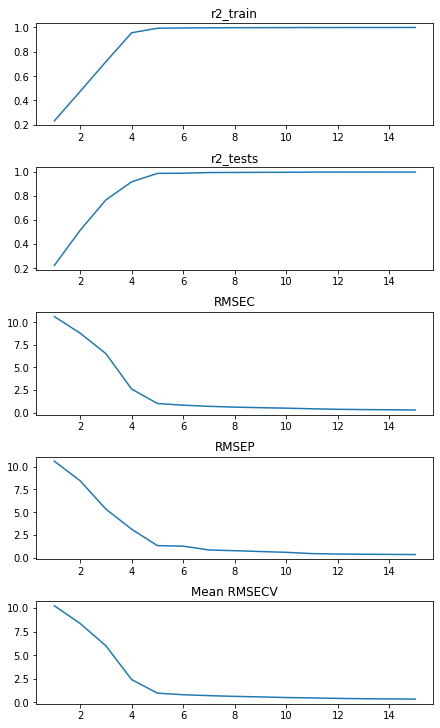

In [4]:
import matplotlib.pyplot as plt

models = [PLSRegression(n_components=i) for i in range(1,16)]
r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVs = score_models(models,
                                                            X_train,
                                                            X_test,
                                                            y_train,
                                                            y_test)
RMSECVm = [i.mean() for i in RMSECVs]
scores = [r2_trains, r2_tests, RMSECs, RMSEPs, RMSECVm]
names = ['r2_train', 'r2_tests', 'RMSEC', 'RMSEP', 'Mean RMSECV']

fig, axs = plt.subplots(5,1, figsize=(6, 10), constrained_layout=True)
axs = axs.flatten()
for score, name, ax in zip(scores, names, axs):
    ax.plot(range(1,16), score)
    ax.set_title(name)

**Answer to question 9.1(b):** The **elbow** in most of the plots is at `n_components=5` so we will pick that as `model A`

**(c)**  Plot the regression coefficients for model A (see point **(b)**).



# components for model A: 5


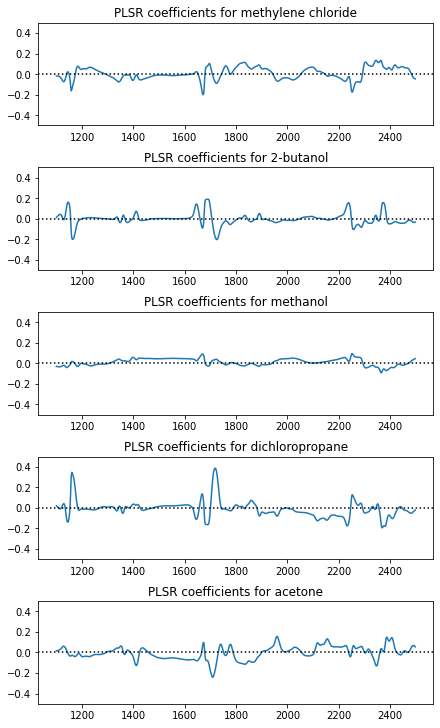

In [5]:
modelA = models[4] # Pick the 5th model
print("# components for model A: {}".format(modelA.n_components))
names = ['methylene chloride', '2-butanol', 'methanol', 'dichloropropane', 'acetone']
B = modelA.coef_
fig, axs = plt.subplots(5, 1, figsize=(6, 10), constrained_layout=True)
axs = axs.flatten()
for i, coef in enumerate(B.T):
    ax = axs[i]
    ax.plot(range(1100, 2500, 2), coef)
    ax.set_title(f'PLSR coefficients for {names[i]}')
    ax.axhline(ls=':', c='k')
    ax.set_ylim(-0.5, 0.5)

**(d)**  If you are given a new spectrum of a mixture of methylene chloride,
2-butanol, methanol, dichloropropane, and acetone, how well would
your model A predict the concentrations of the different solvents
in the mixture?

In [6]:
y_hats = modelA.predict(X_test)
for i, name in enumerate(names):
    print(f"R2 {name}: {r2_score(y_test.T[i],y_hats.T[i])}")

R2 methylene chloride: 0.9904982127276988
R2 2-butanol: 0.993591682558518
R2 methanol: 0.9954324559403975
R2 dichloropropane: 0.9767755713852341
R2 acetone: 0.9845311082597762


**Answer to question 9.1(d):** It will be able to predict the different solvents with more than 97% accuracy

**(e)**  Create a least squares model for predicting the concentrations.
Assess it using $R^2$, RMSEC, RMSECV and RMSEP. Does this model
perform as you expect?

In [7]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
r2_train, r2_test, RMSEC, RMSEP, RMSECV = score_models([model],
                                                       X_train, 
                                                       X_test,
                                                       y_train,
                                                       y_test)
print(f"R2 train: {r2_train[0]}\n" +
      f"R2 test: {r2_test[0]}\n" +
      f"RMSEC: {RMSEC[0]}\n" +
      f"RMSEP: {RMSEP[0]}\n" +
      f"RMSECV: {RMSECV[0].mean()} ± {RMSECV[0].std()}\n"
     )

R2 train: 1.0
R2 test: 0.9994806348296281
RMSEC: 1.164197097195294e-13
RMSEP: 0.290894892607333
RMSECV: 0.16428241719281234 ± 0.07011644258976359



**Answer to question 9.1(e):** It performs well above what we expected. Keep in mind that we have over 700 variables to describe 140 samples, so we might have some overfitting/correlation issues

**Exercise 9.2**

[Schummer *et al.*](https://doi.org/10.1016/S0378-1119(99)00342-X) studied ovarian cancer by measuring gene expression
values for $1536$ genes in both normal and tumor tissues. One of their goals was
to find genes that were overexpressed in tumor samples compared with normal samples.
This knowledge may be used for tumor diagnosis. The raw data can be
found in the file [`Data/ovo.csv`](Data/ovo.csv).


**(a)**  Perform a principal component analysis (PCA) on the gene expression data,
and obtain the explained variance when using $1$, $2$, $5$ and $10$
components.

Center the data before performing the PCA. This can be
done as follows with the `scale` method
from `sklearn.preprocessing`: `X = scale(X, with_std=False)`.

The raw data can
be loaded as shown below.

In [8]:
"""Load the data set."""
import pandas as pd
data = pd.read_csv('Data/ovo.csv')
classes = data['objlabels']  # Classification of data points.
X = data.filter(like='X.', axis=1)  # Gene expressions.

Explained variance for 1 components: 0.12796952939150152
Explained variance for 2 components: 0.2122308624965635
Explained variance for 5 components: 0.35677099070896623
Explained variance for 10 components: 0.48611387173098186


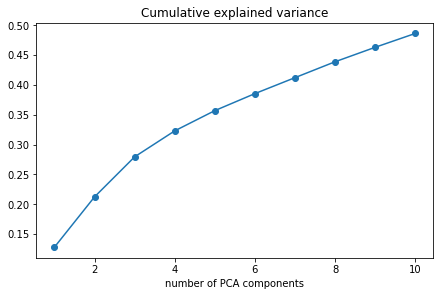

In [9]:
import pandas as pd
data = pd.read_csv('Data/ovo.csv')
classes = data['objlabels']  # Classification of data points.
X = data.filter(like='X.', axis=1)  # Gene expressions.


from sklearn.decomposition import PCA
X = scale(X, with_std=False)


pca = PCA(n_components=10)
pca.fit(X)
expl_var = pca.explained_variance_ratio_
cum_expl_var = [sum(expl_var[:i]) for i in range(1,11)]
figi, axi = plt.subplots(constrained_layout=True)
axi.plot(range(1,11), cum_expl_var, marker='o')
axi.set_title("Cumulative explained variance")
axi.set_xlabel("number of PCA components")
for i in [1, 2, 5, 10]:
    print(f"Explained variance for {i} components: {cum_expl_var[i-1]}")

**(b)**  Inspect the data by plotting the scores and loadings for principal component
number $1$ and principal component number $2$:

* (i)  Can you observe any clustering
of the samples?

* (ii)  Are there any outliers among the samples?

* (iii)  Can you identify some
genes which are overexpressed in tumors? 

* (iv)  Can you identify some
genes which are underexpressed in tumors? 





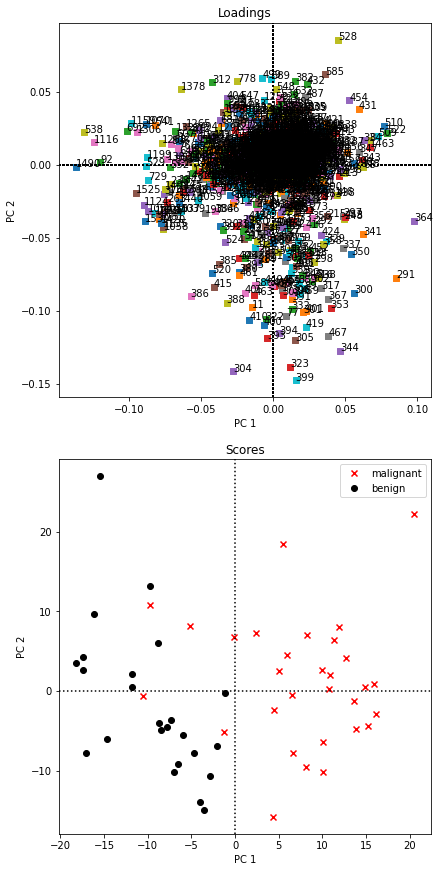

In [10]:
scores = pca.transform(X)
loadings = pca.components_

fig, axs = plt.subplots(2, 1, figsize=(6,12), constrained_layout=True)
axs = axs.flatten()

#plot loadings
ax = axs[0]
for x, y, label in zip(loadings[0, :], loadings[1, :], range(loadings.shape[1])):
    ax.scatter(x, y, marker=',')
    ax.text(x, y, label)
    ax.axhline(ls=':', c='k')
    ax.axvline(ls=':', c='k')
ax.set_title("Loadings")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# Plot scores
ax = axs[1]
# Label malignant cells
s_label = np.array([1 if 'C' in name else 0 for name in data['olabels']])
c = np.where(s_label==1)
n = np.where(s_label==0)

# Plot the malignant cells
ax.scatter(scores[c,0], scores[c,1], c='red', marker='x', label='malignant')

# Plot the benign cells
ax.scatter(scores[n,0], scores[n,1], c='black', marker='o', label='benign')
ax.legend()
ax.axhline(ls=':', c='k')
ax.axvline(ls=':', c='k')
ax.set_title("Scores")

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2");

**Answer to question 9.2(b):**

(i) From looking at the scores plot, PC 1 seems to seperate malignant and benign cells.

(ii) There seems to be about 4 outliers that are on the wrong side of PC 1 from what you would expect

(iii) Looking at the loadings plot (using the zoom function): gene 364, 509, 510, and 511 are in the same direction of PC 1 as the malignant cells in the score plot

(iv) With the same method as (iii): genes 1490, 538, 1116, and 92 seem to have an oposite correlation in PC 1 with malignant cells

**(c)**  Based on your answer in **(b)**, can
you identify some pairs of genes that seem to distinguish between
normal and tumor tissues? Support your findings by plotting the raw data.

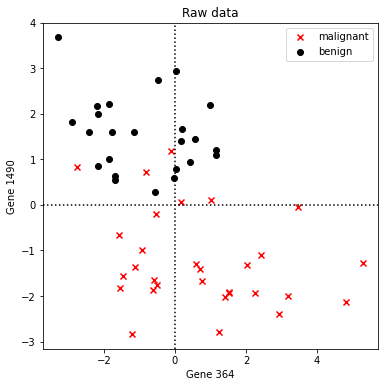

In [11]:
# Your code here
# We will use gene 364 (positive correlation) and 1490 (negative correlation)

fig, ax = plt.subplots(1, 1, figsize=(6,6))

pos = 364
neg = 1490

# Plot the ra data in the same vain as the scores
# Plot the malignant cells
ax.scatter(X[c,pos], X[c,neg], c='red', marker='x', label='malignant')

# Plot the benign cells
ax.scatter(X[n,pos], X[n,neg], c='black', marker='o', label='benign')
ax.legend()
ax.axhline(ls=':', c='k')
ax.axvline(ls=':', c='k')
ax.set_title("Raw data")

ax.set_xlabel(f"Gene {pos}")
ax.set_ylabel(f"Gene {neg}");

**Answer to question 9.2(c):** As you can see in the plot above: having a higher gene 364 has a higher chance of being malignant, while having a higher gene 1490 gives a higher chance of being benign